In [2]:
import os
import sys
import json
import io
import hashlib
import requests
from multiprocessing.dummy import Pool
from functools import partial

import numpy as np

import pandas as pd

from PIL import Image

import tqdm

REPO_DIR = os.path.join(os.environ['HOME'], 'github_repos')
sys.path.append(os.path.join(REPO_DIR, 'partial-data/'))
from partial_data.visualization import draw_bounding_boxes_on_image
from partial_data.tfrecord import (create_label_map_pbtxt, encode_object_detection_tf_example, 
                                   decode_object_detection_tf_example, write_examples_as_tfrecord, 
                                   read_examples_from_tfrecord)

In [3]:
def download_image(image_url, output_dir):
    img_name = os.path.split(image_url)[-1]
    output_filepath = os.path.join(output_dir, img_name)
    try:
        if not os.path.exists(output_filepath):
            img_data = requests.get(image_url).content
            with open(output_filepath, 'wb') as fp:
                fp.write(img_data)
    except:
        return image_url
    else:
        return None
            
            
def download_images(image_urls, output_dir, num_parallel=1):
    with Pool(processes=num_parallel) as pool:
        res = list(tqdm.tqdm(
            pool.imap(partial(download_image, output_dir=output_dir), image_urls),
            total=len(image_urls)
        ))
    return res


def load_coco_annotations_as_dataframe(annotations_filepath, local_image_dir):
    # Load raw data from disk
    with open(annotations_filepath, 'r') as fp:
        instances = json.load(fp)
        
    # Load annotation info into dataframe
    df_ann = (
        pd.DataFrame(instances['annotations'])
        .drop(columns=['segmentation', 'area'])
        .rename(columns={'id': 'instance_id'})
    )

    # Load category info into dataframe
    df_cat = (
        pd.DataFrame(instances['categories'])
        .drop(columns=['supercategory'])
        .rename(columns={'id': 'category_id', 'name': 'category_name'})
    )
    df_cat['category_name_orig'] = df_cat['category_name']
    df_cat['category_name'] = df_cat['category_name'].str.lower().str.replace(' ', '_')

    # Load image info
    df_image = pd.DataFrame(instances['images']).rename(columns={'id': 'image_id'})
    df_image['image_filepath'] = df_image['file_name'].apply(lambda x: os.path.join(local_image_dir, x))
    df_image.drop(columns=['license', 'file_name', 'date_captured', 'flickr_url'], inplace=True)

    # Combine all info into single dataframe
    df_comb = pd.merge(df_ann, df_cat, on='category_id', how='left')
    df_comb = pd.merge(df_comb, df_image, on='image_id', how='left')
    
    # Convert bounding boxes to normalized coordinates
    # Original box coordinates are [x,y,width,height], measured from the top left image corner, and 0-indexed
    df_comb['wmin'] = df_comb['bbox'].str[0] / df_comb['width']
    df_comb['hmin'] = df_comb['bbox'].str[1] / df_comb['height']
    df_comb['wmax'] = (df_comb['bbox'].str[0] + df_comb['bbox'].str[2]) / df_comb['width']
    df_comb['hmax'] = (df_comb['bbox'].str[1] + df_comb['bbox'].str[3]) / df_comb['height']
    
    return df_comb

## Load and process data 

In [4]:
coco_image_val_dir = '/home/david/datasets/coco/val2017/images/val'
coco_image_train_dir = '/home/david/datasets/coco/val2017/images/train'
coco_annotations_val_filepath = '/home/david/datasets/coco/val2017/annotations/instances_val2017.json'
coco_annotations_train_filepath = '/home/david/datasets/coco/val2017/annotations/instances_train2017.json'

In [5]:
# Load data from disk
# df_val = load_coco_annotations_as_dataframe(coco_annotations_val_filepath, coco_image_val_dir)
df_train = load_coco_annotations_as_dataframe(coco_annotations_train_filepath, coco_image_train_dir)

## Create datasets 

In [9]:
# Choose categories to consider, implicitly indicating which should have missing instances
dataset1_cats = {'chair', 'potted_plant', 'couch', 'sink'}
dataset2_cats = {'dining_table', 'vase', 'tv', 'couch', 'sink'}
dataset3_cats = dataset1_cats | dataset2_cats

# Assign images to differnet halves of dataset with missing annotations
np.random.seed(0)
image_ids = df_train['image_id'].unique()
image_id_dataset_mask = np.random.randint(0, 2, len(image_ids)).astype(bool)
image_ids_dataset1 = set(image_ids[image_id_dataset_mask].tolist())
image_ids_dataset2 = set(image_ids[~image_id_dataset_mask].tolist())
is_dataset1_image = df_train['image_id'].isin(image_ids_dataset1)
is_dataset2_image = df_train['image_id'].isin(image_ids_dataset2)

# Identify instances belonging to valid categories
is_dataset1_cat = df_train['category_name'].isin(dataset1_cats)
is_dataset2_cat = df_train['category_name'].isin(dataset2_cats)
is_dataset3_cat = df_train['category_name'].isin(dataset3_cats)

# Identify valid instances for two halves of dataset with partial annotations
is_dataset1_instance = is_dataset1_image & is_dataset1_cat
is_dataset2_instance = is_dataset2_image & is_dataset2_cat
is_dataset12_instance = is_dataset1_instance | is_dataset2_instance

# Identify valid instances for dataset with complete annotations
image_ids_dataset12 = set(df_train.loc[is_dataset12_instance, 'image_id'].tolist())
is_dataset3_image = df_train['image_id'].isin(image_ids_dataset12)
is_dataset3_instance = is_dataset3_image & is_dataset3_cat

# Create dataframes for datasets with partial and complete annotations
df_dataset12 = df_train[is_dataset12_instance].copy()
df_dataset3 = df_train[is_dataset3_instance].copy()

# Create new sequential label ids for retained categories
category_id_map_new = {nm: ind for ind, nm in enumerate(dataset3_cats, 1)}
df_dataset12['category_id_orig'] = df_dataset12['category_id']
df_dataset3['category_id_orig'] = df_dataset3['category_id']
df_dataset12['category_id'] = df_dataset12['category_name'].apply(lambda x: category_id_map_new[x])
df_dataset3['category_id'] = df_dataset3['category_name'].apply(lambda x: category_id_map_new[x])

In [10]:
# Get total instance and image counts
num_images1 = df_train.loc[is_dataset1_instance, 'image_id'].nunique()
num_images2 = df_train.loc[is_dataset2_instance, 'image_id'].nunique()
num_images3 = df_train.loc[is_dataset3_instance, 'image_id'].nunique()
print(f'dataset 1 - num images: {num_images1}, num instances: {is_dataset1_instance.sum()}')
print(f'dataset 2 - num images: {num_images2}, num instances: {is_dataset2_instance.sum()}')
print(f'dataset 3 - num images: {num_images3}, num instances: {is_dataset3_instance.sum()}')

# Get per category instance counts 
pd.concat(
    [
        df_train.loc[is_dataset1_instance, 'category_name'].value_counts().rename('dataset1'),
        df_train.loc[is_dataset2_instance, 'category_name'].value_counts().rename('dataset2'),
        df_train.loc[is_dataset3_instance, 'category_name'].value_counts().rename('dataset3'),
    ],
    axis=1
).sort_values(by='dataset3', ascending=False).astype(pd.Int64Dtype())

dataset 1 - num images: 10562, num instances: 29207
dataset 2 - num images: 11790, num instances: 19701
dataset 3 - num images: 22352, num instances: 70348


,dataset1,dataset2,dataset3
chair,19251,<NA>,30065
dining_table,<NA>,7853,12307
potted_plant,4270,<NA>,6745
couch,2899,2880,5779
sink,2787,2823,5610
vase,<NA>,3350,5371
tv,<NA>,2795,4471


## Download images 

In [45]:
%%time
urls = np.unique(df_dataset3['coco_url'])
res = download_images(urls, coco_image_train_dir, num_parallel=10)

100%|██████████| 22352/22352 [26:25<00:00, 14.10it/s]  

CPU times: user 12min 44s, sys: 6min 11s, total: 18min 55s
Wall time: 26min 25s


## Visualize bounding boxes  

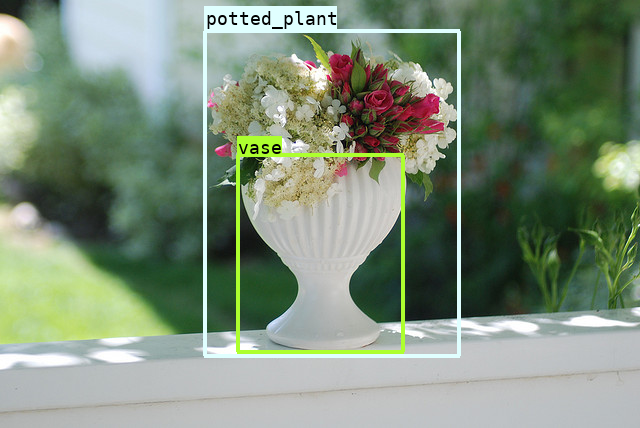

In [60]:
ind = 0

image_grps = df_dataset3.groupby('image_filepath')
image_filepaths = list(image_grps.groups.keys())
image_filepath = image_filepaths[ind]
df_image_grp = image_grps.get_group(image_filepath)
bboxes = df_image_grp[['hmin', 'wmin', 'hmax', 'wmax']].values
labels = [(nm,) for nm in df_image_grp['category_name']]
img = Image.open(image_filepath)
font_filepath = '/home/david/github_repos/fonts/DejaVuSansMono/DejaVu Sans Mono for Powerline.ttf'
draw_bounding_boxes_on_image(img, bboxes, 
                             font_size=18, font_filepath=font_filepath, 
                             display_str_list_list=labels)
img

## Split datasets into train/val/test

In [61]:
# Define split parameters
train_frac = 0.7
val_frac = 0.1
np.random.seed(0)

# Assign images to different splits
num_train = round(len(image_ids) * train_frac)
num_val = round(len(image_ids) * val_frac)
image_ids_shuffle = np.random.permutation(image_ids)
image_ids_train = set(image_ids_shuffle[:num_train].tolist())
image_ids_val = set(image_ids_shuffle[num_train:num_train+num_val].tolist())
image_ids_test = set(image_ids_shuffle[num_train+num_val:].tolist())

# Create dataframes with different splits
df_dataset12_train = df_dataset12[df_dataset12['image_id'].isin(image_ids_train)]
df_dataset12_val = df_dataset12[df_dataset12['image_id'].isin(image_ids_val)]
df_dataset12_test = df_dataset12[df_dataset12['image_id'].isin(image_ids_test)]
df_dataset3_train = df_dataset3[df_dataset3['image_id'].isin(image_ids_train)]
df_dataset3_val = df_dataset3[df_dataset3['image_id'].isin(image_ids_val)]
df_dataset3_test = df_dataset3[df_dataset3['image_id'].isin(image_ids_test)]

In [62]:
# Check image and instance counts per split
df_split_count = pd.DataFrame(
    [
        [df_dataset12_train['image_id'].nunique(), df_dataset12_val['image_id'].nunique(), df_dataset12_test['image_id'].nunique()],
        [df_dataset3_train['image_id'].nunique(), df_dataset3_val['image_id'].nunique(), df_dataset3_test['image_id'].nunique()],
        [len(df_dataset12_train), len(df_dataset12_val), len(df_dataset12_test)],
        [len(df_dataset3_train), len(df_dataset3_val), len(df_dataset3_test)]
    ],
    index=['num_images_12', 'num_images_3', 'num_instances_12', 'num_instances_3'],
    columns=['train', 'val', 'test']
)
df_split_count['all'] = df_split_count.sum(axis=1)
df_split_count

,train,val,test,all
num_images_12,15595,2275,4482,22352
num_images_3,15595,2275,4482,22352
num_instances_12,33854,5115,9939,48908
num_instances_3,48766,7334,14248,70348


## Save annotation datasets to disk 

In [64]:
output_dir = './annotations'
dataset12_prefix = 'annotations_partial_'
dataset3_prefix = 'annotations_complete_'

df_dataset12_train.to_csv(os.path.join(output_dir, dataset12_prefix+'train.csv'), index=False)
df_dataset12_val.to_csv(os.path.join(output_dir, dataset12_prefix+'val.csv'), index=False)
df_dataset12_test.to_csv(os.path.join(output_dir, dataset12_prefix+'test.csv'), index=False)
df_dataset3_train.to_csv(os.path.join(output_dir, dataset3_prefix+'train.csv'), index=False)
df_dataset3_val.to_csv(os.path.join(output_dir, dataset3_prefix+'val.csv'), index=False)
df_dataset3_test.to_csv(os.path.join(output_dir, dataset3_prefix+'test.csv'), index=False)